Code for creating `epochs.pkl` from raw dataset. Skip this block.

In [1]:
#from lbhb.io import abr
#path = '/auto/data/daq/gerbil/physiology/interleaved/mouse/5dB_int_vs_seq_int_mode/20181025-1454 BK 1381 left I40 abr/'
#experiment = abr.ABRExperiment(path)
#gain, reject = experiment.get_info(['amplifier_gain', 'reject_threshold'])
#epochs = experiment.get_epochs() * gain
#mask = epochs < reject
#mask = mask.all(axis=1)
#epochs = epochs.loc[mask].xs(16000, level='frequency')
#epochs.to_pickle('epochs.pkl')

In [2]:
import matplotlib.pyplot as plt
import matplotlib.transforms as T
import numpy as np
import pandas as pd
import string

epochs = pd.read_pickle('epochs.pkl')
mean_epochs = epochs.groupby('level').mean()
threshold = 25

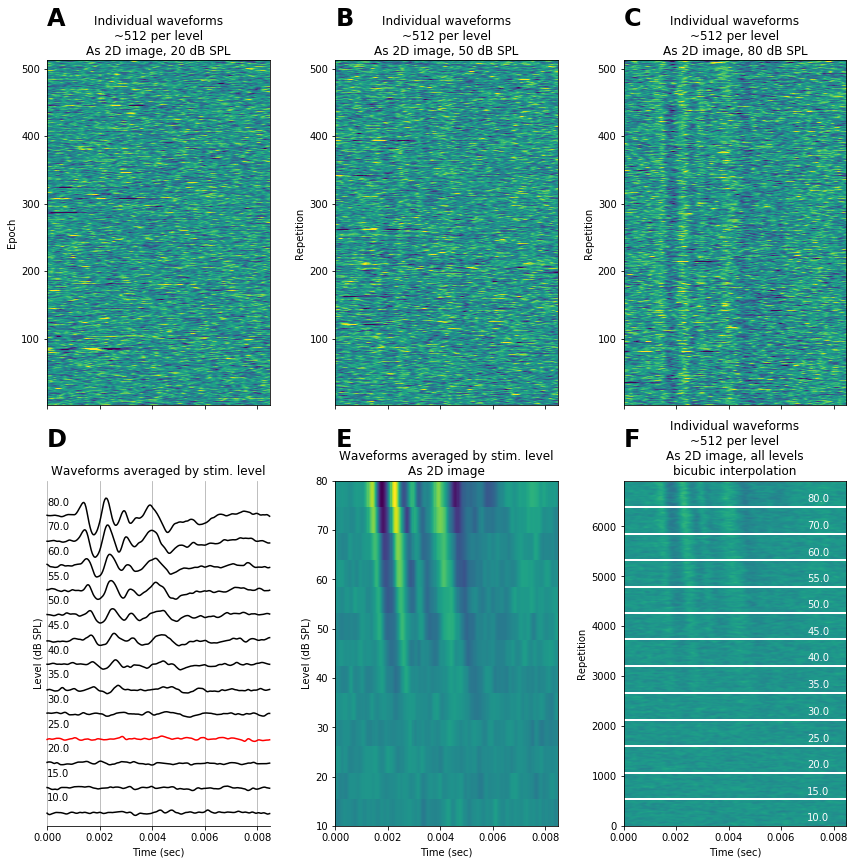

In [3]:
def plot_waterfall(ax, waveforms, threshold=None):
    n = len(waveforms)
    offset_step = 1/(n+1)
    plots = []

    text_trans = T.blended_transform_factory(ax.figure.transFigure,
                                             ax.transAxes)


    limits = [(w.min(), w.max()) for _, w in waveforms.iterrows()]
    base_scale = np.mean(np.abs(np.array(limits)))

    bscale_in_box = T.Bbox([[0, -base_scale], [1, base_scale]])
    bscale_out_box = T.Bbox([[0, -1], [1, 1]])
    bscale_in = T.BboxTransformFrom(bscale_in_box)
    bscale_out = T.BboxTransformTo(bscale_out_box)

    tscale_in_box = T.Bbox([[0, -1], [1, 1]])
    tscale_out_box = T.Bbox([[0, 0], [1, offset_step]])
    tscale_in = T.BboxTransformFrom(tscale_in_box)
    tscale_out = T.BboxTransformTo(tscale_out_box)

    boxes = {
        'tscale': tscale_in_box,
        'tnorm': [],
        'norm_limits': limits/base_scale,
    }

    for i, (level, waveform) in enumerate(waveforms.iterrows()):
        y_min, y_max = waveform.min(), waveform.max()
        tnorm_in_box = T.Bbox([[0, -1], [1, 1]])
        tnorm_out_box = T.Bbox([[0, -1], [1, 1]])
        tnorm_in = T.BboxTransformFrom(tnorm_in_box)
        tnorm_out = T.BboxTransformTo(tnorm_out_box)
        boxes['tnorm'].append(tnorm_in_box)

        offset = offset_step * i + offset_step * 0.5
        translate = T.Affine2D().translate(0, offset)

        y_trans = bscale_in + bscale_out + \
            tnorm_in + tnorm_out + \
            tscale_in + tscale_out + \
            translate + ax.transAxes
        trans = T.blended_transform_factory(ax.transData, y_trans)
        
        c = 'r' if threshold is not None and level == threshold else 'k'
        ax.plot(waveform.index, waveform.values, '-', color=c, transform=trans, clip_on=False)

        text_trans = T.blended_transform_factory(ax.transAxes, y_trans)
        ax.text(0.0, 0, f'{level}', transform=text_trans)

    ax.set_yticks([])
    ax.grid()
    for spine in ('top', 'left', 'right'):
        ax.spines[spine].set_visible(False)

figure, axes = plt.subplots(2, 3, figsize=(12, 12), sharey=False, sharex=True)

plot_waterfall(axes[1, 0], mean_epochs, threshold=threshold)
extent = (mean_epochs.columns.min(), mean_epochs.columns.max(), 
          mean_epochs.index.min(), mean_epochs.index.max())
axes[1, 1].imshow(mean_epochs, aspect='auto', origin='lower left', extent=extent)

epochs = epochs.sort_index()
vmin, vmax = np.percentile(epochs, [0.1, 99.9])
extent = (mean_epochs.columns.min(), mean_epochs.columns.max(), 0, len(epochs))
axes[1, 2].imshow(epochs, aspect='auto', origin='lower left', extent=extent, vmin=vmin, vmax=vmax, interpolation='bicubic')

axes[1, 0].set_title('Waveforms averaged by stim. level')
axes[1, 1].set_title('Waveforms averaged by stim. level\nAs 2D image')
axes[1, 2].set_title('Individual waveforms\n~512 per level\nAs 2D image, all levels\nbicubic interpolation')

extent = (mean_epochs.columns.min(), mean_epochs.columns.max(), 1, 512)
axes[0, 0].imshow(epochs.xs(20, level='level'), aspect='auto', origin='lower left', extent=extent, vmin=vmin, vmax=vmax)
axes[0, 1].imshow(epochs.xs(50, level='level'), aspect='auto', origin='lower left', extent=extent, vmin=vmin, vmax=vmax)
axes[0, 2].imshow(epochs.xs(80, level='level'), aspect='auto', origin='lower left', extent=extent, vmin=vmin, vmax=vmax)
axes[0, 0].set_title('Individual waveforms\n~512 per level\nAs 2D image, 20 dB SPL')
axes[0, 1].set_title('Individual waveforms\n~512 per level\nAs 2D image, 50 dB SPL')
axes[0, 2].set_title('Individual waveforms\n~512 per level\nAs 2D image, 80 dB SPL')


o = 0
for l, df in epochs.groupby('level'):
    axes[1, 2].text(0.007, o+100, f'{l}', color='w')
    o += len(df)
    axes[1, 2].axhline(o, color='w', lw=2)
    
for ax in axes[0, :]:
    ax.set_ylabel('Repetition')
    
for ax in axes[1, :]:
    ax.set_xlabel('Time (sec)')
    
axes[0, 0].set_ylabel('Epoch')
#axes[1, 0].set_ylabel('Level (dB SPL)')
axes[1, 2].set_ylabel('Repetition')
axes[1, 1].set_ylabel('Level (dB SPL)')
axes[1, 0].set_ylabel('Level (dB SPL)')
    
figure.tight_layout()
figure.savefig('example_plots.png')

for letter, ax in zip(string.ascii_uppercase, axes.ravel()):
    ax.text(0, 1.1, letter, transform=ax.transAxes, fontsize=24, fontweight='bold')

# Description of data 

The auditory brainstem response (ABR) is a signal that represents the activity of various auditory brainstem nuclei. To acquire this signal, we present a tone pip repeatedly to the ear and measure the response using electrodes. We present multiple sound levels from 10 to 80 dB SPL. As the sound level increases, the waveform becomes larger. Threshold is defined as the minimum sound level at which we can detect the ABR in the waveform. 

Since the signal is so noisy, we cannot see the ABR response in individual waveforms. We acquire ~512 repetitions and average the waveforms together to obtain a measurable response. The top row shows the individual waveforms for each of three different sound levels (20, 50 and 80 dB SPL). The x-axis is time and the y-axis is the repetition. 

The threshold for this particular experiment (as estimated by a human visually inspecting the stacked waveforms in panel *D*) is 25 dB SPL. The first plot (*A*, 20 dB SPL) does not have a visible pattern across the repetitions since the sound level is sub-threshold. At 50 dB SPL (*B*), we can see a faint pattern in the image. The pattern is very apparent at 80 dB SPL (*C*) as the ABR response becomes stronger.

Plot *D* and *E* shows the average waveform for each sound level (the data is the same, but the visualization is different). Plot *F* stacks all the individual repetitions from each sound level. The white line delineates the stacked waveforms from each sound level.

# Problem

My goal is to automate the detection of threshold. I have hundreds (possibly thousands) of datasets for which I have identified threshold. The input of the model can be either a 3D array containing all levels, repetitions for each level and timepoints for each repetition. Alternatively, I could use a 2D array containing the average waveforms (i.e., we would average the 3D array across repetitions to get a 2D array). The output of the model would be the predicted threshold of the dataset.

Ideally I’d be able to build a model that uses the individual repetitions since I’d like a model that’s robust to dropping some stimulus levels (e.g., if we only collect sound levels in 10 dB steps rather than 5 dB steps, can we still accurately estimate threshold?). If the model only takes the average waveforms, then it’s less likely to be able to handle this.

I’d appreciate any suggestions you have for how to build the architecture using a machine learning library such as keras. 

If it helps, I have performed some attempts to build my own approach using a cross-correlation approach. For each level, I compute the correlation coefficient between all possible pairs of the 512 repetitions giving us $n(n-1)/2$, or 130816, correlations. Taking the mean value of the 130816 correlations per level gives us a correlation vs level function. I'd then look at the poitn where the function crosses a particular threshold. It seems to work most of the time, but I'm hoping that a machine learning algorithm can improve this approach.

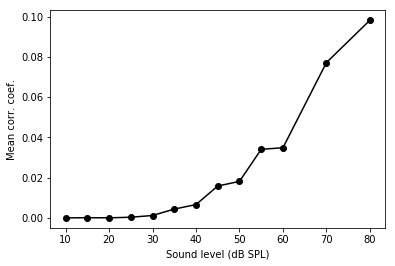

In [4]:
def compute_cc(x):
    cc = np.corrcoef(x.iloc[:512].values)
    i, j = np.tril_indices_from(cc, k=-1)
    result = cc[i, j]
    return result.mean()

cc = epochs.groupby('level').apply(compute_cc)
plt.plot(cc.index, cc.values, 'ko-')
plt.xlabel('Sound level (dB SPL)')
plt.ylabel('Mean corr. coef.');

In case you need to look at the raw data, here's some code for converting the dataframe to a 3D array of level x repetition x time.

Due to the way data acquisition works, there are actually a variable number of repetitons per level. However, we always require a minimum of 512 repetitions per level. The following code builds a 3D Numpy array from the dataframe and discards any extra repetitions.

In [5]:
n_levels = len(epochs.index.get_level_values('level').unique())
n_repetitions = 512
n_timepoints = epochs.shape[-1]

epochs_array = np.empty((n_levels, n_repetitions, n_timepoints))
for i, (_, df) in enumerate(epochs.groupby('level')):
    epochs_array[i] = df.iloc[:512].values

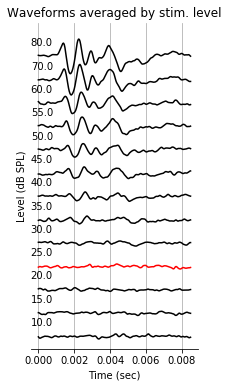

In [10]:
figure, axes = plt.subplots(1, 1, figsize=(3, 6), sharey=False, sharex=True)

plot_waterfall(axes, mean_epochs, threshold=threshold)
extent = (mean_epochs.columns.min(), mean_epochs.columns.max(), 
          mean_epochs.index.min(), mean_epochs.index.max())
axes.set_title('Waveforms averaged by stim. level')
axes.set_ylabel('Level (dB SPL)')
axes.set_xlabel('Time (sec)')

figure.savefig('waterfall_plot.png')

In [ ]:
    
#figure.tight_layout()
#figure.savefig('example_plots.png')
#
#for letter, ax in zip(string.ascii_uppercase, axes.ravel()):
#    ax.text(0, 1.1, letter, transform=ax.transAxes, fontsize=24, fontweight='bold')